In [37]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import datetime
from sklearn import metrics
from sklearn.utils import class_weight
from PIL import Image
import time
import os
import torchvision
import torchsummary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

import torchmetrics

In [38]:
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [39]:
# Creo un pipeline para transformar las imágenes.
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (200, 200)),
    torchvision.transforms.ToTensor()])

# Creo un pipeline para las transformaciones de augmentations.
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size = (200, 200)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size = (200, 200), scale = (0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation = 0.1, hue = 0.1),
                        torchvision.transforms.ToTensor(),
                      ])

In [40]:
# Cargo imágenes de train, validación y test.
train_set = torchvision.datasets.ImageFolder(root = r'C:\Users\Leandro\CEIA_Analisis_de_datos\VPC2\TP\archive\animal_dataset\Remaining_train', transform = aug_data_transforms)
valid_set = torchvision.datasets.ImageFolder(root = r'C:\Users\Leandro\CEIA_Analisis_de_datos\VPC2\TP\archive\animal_dataset\Remaining_valid', transform = aug_data_transforms)
test_set = torchvision.datasets.ImageFolder(root = r'C:\Users\Leandro\CEIA_Analisis_de_datos\VPC2\TP\archive\animal_dataset\test', transform = aug_data_transforms)

train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 64, shuffle = True)

In [41]:
# Cargo modelo base
vgg19_model = torchvision.models.vgg19(weights = weights)

vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size = (3, 200, 200))
vgg19_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             ReLU-14          [-1, 256,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

In [42]:
# Congelo capas de red base
for param in vgg19_model.parameters():
    param.requires_grad = False

In [43]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features = 10)

In [44]:
labels = list(test_set.class_to_idx.keys())
vgg19_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [ ]:
# Determino vector de pesos para equilibrar el desbalance.
labels_list = [train_set[i][1] for i in range(len(train_set))]

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.arange(10), 
    y = np.array(labels_list))
class_weights = torch.tensor(class_weights, dtype = torch.float)
    
if torch.cuda.is_available():
    class_weights = class_weights.to("cuda")

class_weights

In [45]:
optimizer_ft = torch.optim.Adam(vgg19_model.parameters(), lr = 0.0001)
criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

In [46]:
# Defino funciones de guardar y cargar modelo.
def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)

def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch

In [47]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes = 10)

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

        path = f'C:/Users/Leandro/CEIA_Analisis_de_datos/VPC2/TP/model1({now}).pth'
        
        save_checkpoint(model, optimizer, path, epoch)

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [48]:
# Cargo el mejor modelo entrenado.
new_model, new_optimizer, _ = load_checkpoint(vgg19_model, optimizer_ft, r'C:\Users\Leandro\CEIA_Analisis_de_datos\VPC2\TP\best_model.pth')

### TENSORBOARD

In [ ]:
writer = SummaryWriter(r'C:\Users\Leandro\Desktop\avergastón\runs')

#dataiter_og = iter(train_loader_og)
#dataiter_aug = iter(train_loader_aug)
#images_og, labels = subset_og
#images_aug, labels = subset_aug

#writer.add_graph(vgg19_model, images)

# Add image
img_grid_og = torchvision.utils.make_grid(images_og)
img_grid_aug = torchvision.utils.make_grid(images_aug)
writer.add_image('images_og', img_grid_og)
writer.add_image('images_aug', img_grid_aug)

#for i in range(5):
#    writer.add_scalars('Loss', {'train_loss':history["train_loss"][i],
#                                'test_loss':history["valid_loss"][i]}, i)

writer.close()

### TEST

In [49]:
def make_pred(model, img, labels, print_img = True, return_probs = True):
    model.eval()
    model.to('cpu')    
    img_mat = Image.open(img)
    img_mat_copy = img_mat.copy()
    x = data_transforms(img_mat)
    x = torch.unsqueeze(x, 0)
    output = model(x)
    print(labels[torch.max(output, 1)[1].item()])
    softmax = torch.nn.Softmax(dim=1)
    probs = np.round(softmax(output).detach().numpy()[0],4)
    probs_dict = dict(zip(labels, probs))
    if print_img:
        plt.imshow(img_mat_copy)
        plt.show()
    if return_probs:
        return probs_dict

dog


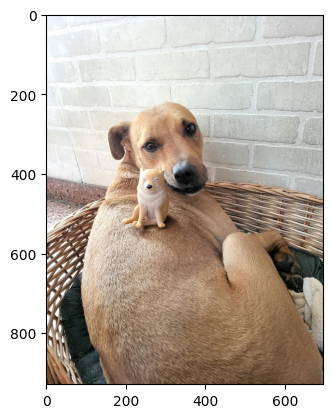

{'butterfly': 0.0,
 'cat': 0.0463,
 'chicken': 0.0158,
 'cow': 0.0015,
 'dog': 0.8466,
 'elephant': 0.0071,
 'horse': 0.0035,
 'sheep': 0.0467,
 'spider': 0.0,
 'squirrel': 0.0324}

In [50]:
img = r'C:\Users\Leandro\Downloads\20220712_100826.jpg'
make_pred(new_model, img, labels, True, True)

### GRAD CAM

In [51]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # get the model network
        self.model = new_model
        
        # disect the network to access its last convolutional layer
        self.features_conv = torch.nn.Sequential(*list(self.model.children())[:-1])
        # self.features_conv = self.model.features[:36]
        
        # get the max pool of the features stem
        # self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
                
        # get the classifier of the vgg19
        self.classifier = self.model.classifier
        
        # placeholder for the gradients
        self.gradients = None

        for param in self.model.parameters():
            param.requires_grad = True
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        # x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

dog


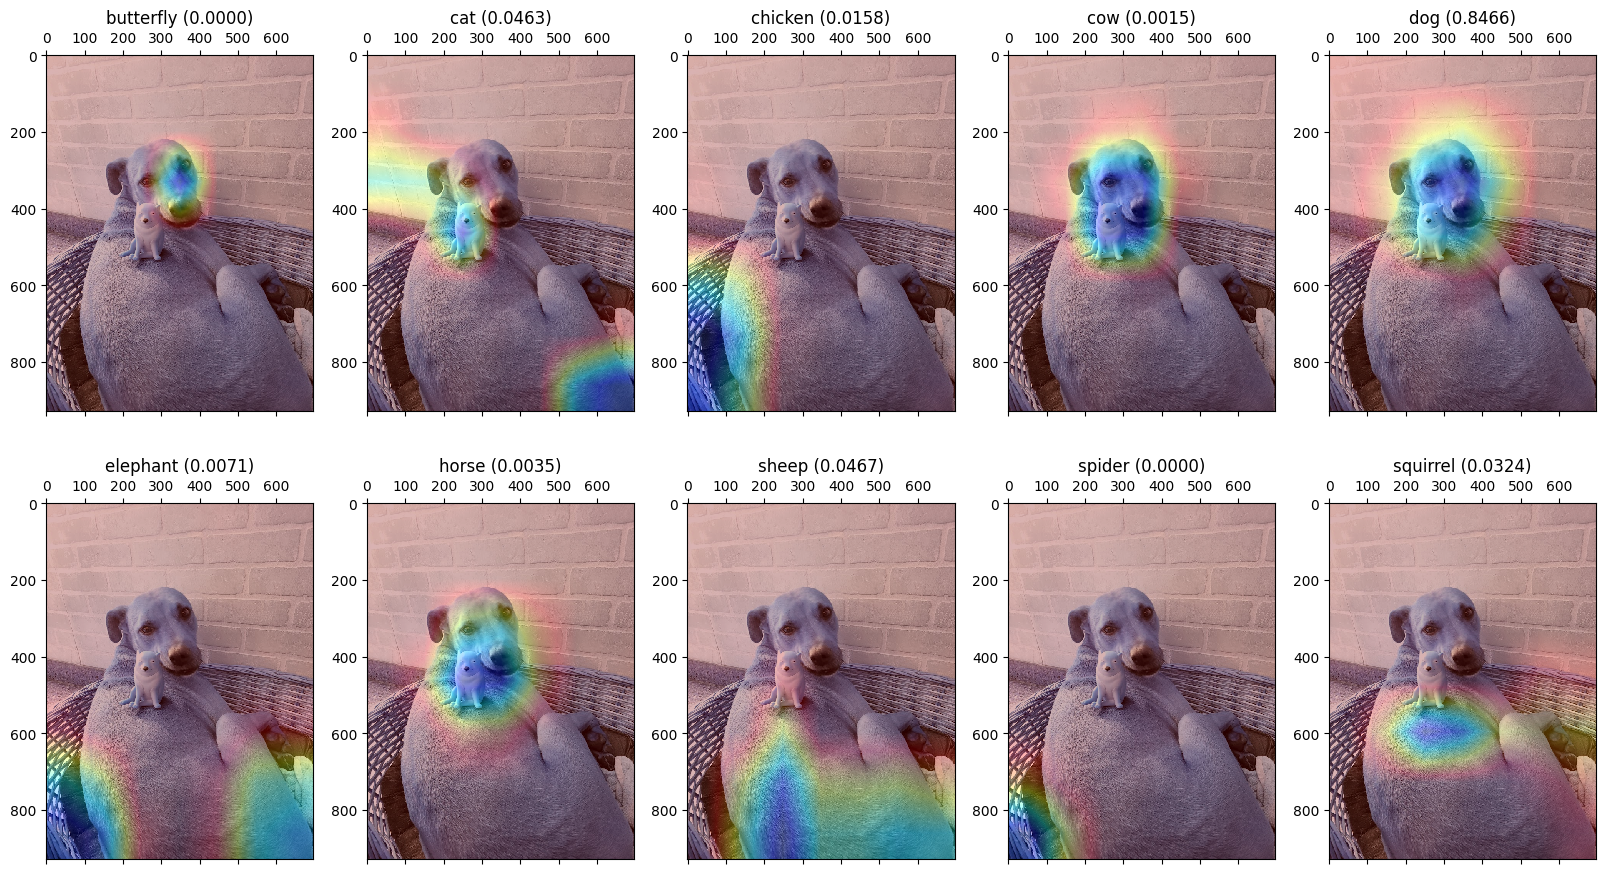

In [52]:
path = 'C:/Users/Leandro/CEIA_Analisis_de_datos/VPC2/TP/archive/animal_dataset/single'
folder = 'single'
img_name = '20220712_100826.jpg'

# define a 1 image dataset
single_set = torchvision.datasets.ImageFolder(root = path, transform = data_transforms)

# define the dataloader to load that single image
single_dataloader = DataLoader(dataset = single_set, shuffle = False, batch_size = 1)

# get the image from the dataloader
img, _ = next(iter(single_dataloader))

# load image to mix with heatmap
back_img = cv.imread(f'{path}/{folder}/{img_name}')

# img shape
h, w, c = back_img.shape

# aspect ratio
aspect_ratio = h / w

# initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 5, figsize = (20, 8 * aspect_ratio))

# make prediction and save probs
probs = make_pred(new_model, f'{path}/{folder}/{img_name}', labels, False, True)

for c in range(10):

    row = c // 5
    col = c % 5

    # initialize the VGG model
    best_model = Model()

    # set the evaluation mode
    best_model.eval()

    # get the most likely prediction of the model
    pred = best_model(img)

    # get the gradient of the output with respect to the parameters of the model
    pred[:,c].backward()

    # pull the gradients out of the model
    gradients = best_model.get_activations_gradient()
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # get the activations of the last convolutional layer
    activations = best_model.get_activations(img).detach()
    
    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)
    
    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    
    # draw the heatmap
    # plt.matshow(heatmap.squeeze())
    
    heatmap = cv.resize(heatmap.numpy(), (back_img.shape[1], back_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)

    superimposed_img = cv.addWeighted(back_img, 0.7, heatmap, 0.3, 0)
    axis[row, col].matshow(superimposed_img)
    axis[row, col].set_title(f'{list(probs.keys())[c]} ({list(probs.values())[c]:.4f})')

plt.show()

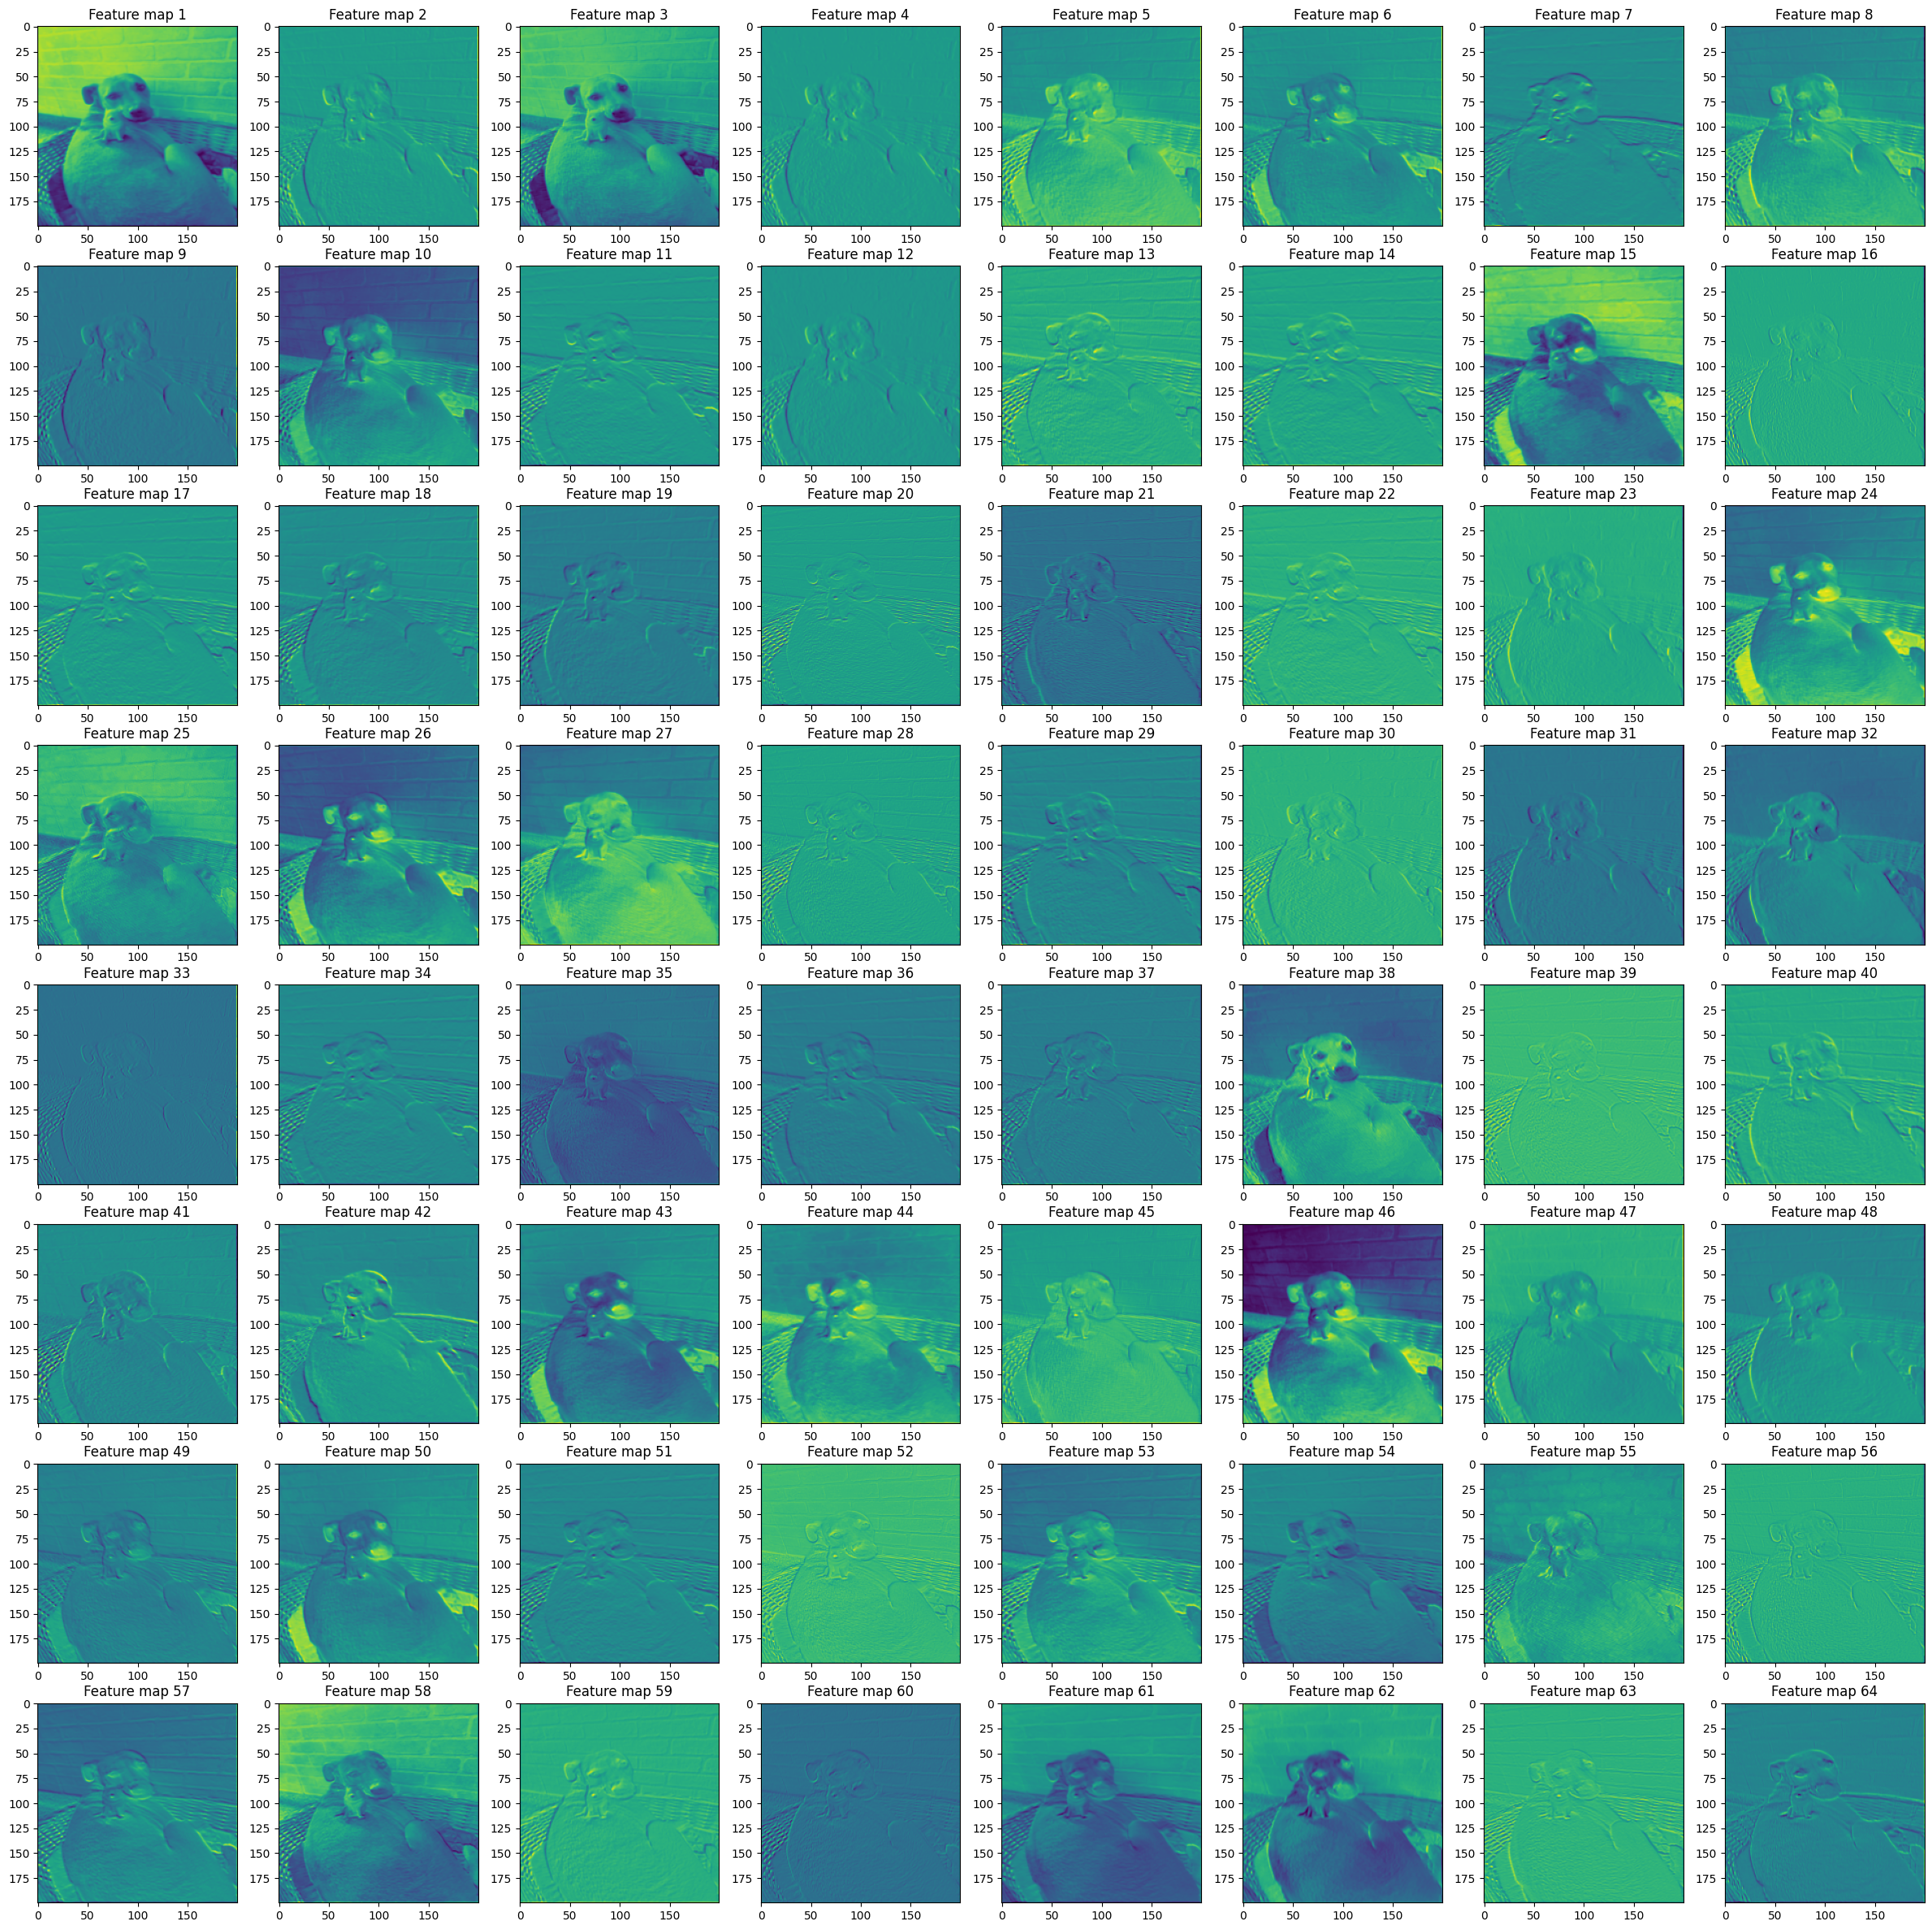

In [165]:
figure, axis = plt.subplots(8, 8, figsize = (30, 30))
for i in range(64):
    row = i // 8
    col = i % 8
    layer_img = layer(img)[:,i,:,:]
    layer_img = layer_img.movedim(0, -1)
    layer_img = layer_img.detach().numpy()
    axis[row, col].imshow(layer_img)
    axis[row, col].set_title(f'Feature map {i+1}')
plt.show()